In [1]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install selenium

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install webdriver_manager

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install dateparser

Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unicodedata
import os
import yfinance as yf
import math
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from matplotlib.dates import DateFormatter
import statistics
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob, Word
from datetime import datetime, timedelta
import time

In [6]:
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jains\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jains\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jains\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jains\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jains\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Web scrapping of news

In [7]:
import os
current_directory = os.getcwd()

In [8]:
tickers = ['TSLA', 'SMCI', 'AMZN', 'AVGO', 'ALB', 'AAPL']
stock_tweet_path=current_directory+"/stock_tweets.csv"
stock_data_path=current_directory+"/stock_yfinance_data.csv"

In [10]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time

# Setup Selenium WebDriver
service = Service(ChromeDriverManager().install())
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--headless")  # Enable headless mode
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")
driver = webdriver.Chrome(service=service, options=chrome_options)

tickers = ['TSLA', 'SMCI', 'AMZN', 'AVGO', 'ALB', 'AAPL']

def last_12_months(time_text):
    if 'months' in time_text:
        months = int(time_text.split()[0])
        return months <= 12
    return True

# Initialize an empty DataFrame to collect all news
headlines = pd.DataFrame()

for ticker in tickers:
    url = f'https://finance.yahoo.com/quote/{ticker}/news/'
    driver.get(url)
    time.sleep(4)
    print(f'Collecting news related to {ticker}')
    previous_height = driver.execute_script('return document.body.scrollHeight')
    count = 0
    news = []
    
    while True:
        content_divs = driver.find_elements(By.CSS_SELECTOR, 'div.content.svelte-w27v8j')
        
        latest_time_text = ''
        for content_div in content_divs:
            try:
                a_tag = content_div.find_element(By.CSS_SELECTOR, 'a.subtle-link.fin-size-small.titles.noUnderline.svelte-wdkn18')
                title = a_tag.get_attribute('title') if a_tag else None
                
                publishing_div = content_div.find_element(By.CSS_SELECTOR, 'div.publishing.font-condensed.svelte-1k3af9g')
                time_text = publishing_div.text.split('•')[-1].strip() if publishing_div else None
                latest_time_text = time_text
                if latest_time_text and last_12_months(latest_time_text):
                    news.append({'Date': time_text, 'Headline': title, 'Stock Name': ticker})
            except Exception as e:
                print(f"Error extracting data: {e}")

        driver.execute_script('window.scrollTo(0, document.body.scrollHeight)')
        time.sleep(4)
        new_height = driver.execute_script('return document.body.scrollHeight')
        
        if new_height == previous_height:
            count += 1
            if count > 4:
                break
        else:
            previous_height = new_height
            count = 0
        
        if latest_time_text and not last_12_months(latest_time_text):
            break
    
    df_news = pd.DataFrame(news)
    
    if not df_news.empty:
        print(f'Starting news related to {ticker} is {df_news["Date"].iloc[0]}')
        print(f'Ending news related to {ticker} is {df_news["Date"].iloc[-1]}')
        print('Dataset size is ', df_news.shape[0])
        headlines = pd.concat([headlines, df_news], ignore_index=True)

# Close the WebDriver
driver.quit()

Starting news related to TSLA is 4 hours ago
Ending news related to TSLA is 6 days ago
Dataset size is  1140
Starting news related to SMCI is 12 minutes ago
Ending news related to SMCI is last month
Dataset size is  1120
Starting news related to AMZN is 7 hours ago
Ending news related to AMZN is yesterday
Dataset size is  120
Starting news related to AVGO is 22 hours ago
Ending news related to AVGO is yesterday
Dataset size is  120
Starting news related to ALB is 22 hours ago
Ending news related to ALB is 28 days ago
Dataset size is  120
Starting news related to AAPL is 5 hours ago
Ending news related to AAPL is yesterday
Dataset size is  120


In [11]:
import requests
import time

def fetch_data(year, month, api_key):
    url = f"https://api.nytimes.com/svc/archive/v1/{year}/{month}.json?api-key={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        articles = data['response']['docs']
        return articles
    else:
        print(f"Failed to fetch data for {year}-{month}: {response.status_code}")
        return []

# Initialize lists for headlines and dates
all_headlines = []
all_dates = []

# API key
api_key = 'Z7LiuLGnozS868StkM3QcbQhsJA8acDt'

# Fetch data for each year from 2010 to 2024
for year in range(2020, 2024):
    for month in range(1, 13):
        print(f"Fetching data for {year}-{month}")
        try:
            articles = fetch_data(year, month, api_key)
            if articles:
                all_headlines.extend([article['headline']['main'] for article in articles])
                all_dates.extend([article['pub_date'] for article in articles])
            # Sleep to respect API rate limits
            time.sleep(6)  # Adjust sleep time as needed based on API rate limits
        except Exception as e:
            print(f"Error fetching data for {year}-{month}: {e}")

# Create a DataFrame
df = pd.DataFrame({'datetime': all_dates, 'news': all_headlines})

# Convert datetime column to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Extract date
df['date'] = df['datetime'].dt.date

# Filter articles containing information about Apple company stock
keywords = ['Apple', 'AAPL', 'Apple Inc', 'apple stock', 'apple shares']
df['contains_apple_stock_info'] = df['news'].apply(lambda x: any(keyword in x for keyword in keywords))

# Create a filtered DataFrame
apple_stock_df = df[df['contains_apple_stock_info']]

# Group by date and concatenate news articles
grouped_apple_df = apple_stock_df.groupby('date')['news'].agg(' '.join).reset_index()

# Rename columns and convert Date to datetime format
grouped_apple_df.columns = ['Date', 'news_articles']
grouped_apple_df['Date'] = pd.to_datetime(grouped_apple_df['Date'])

# Print the resulting DataFrame
print(grouped_apple_df)


Fetching data for 2020-1
Fetching data for 2020-2
Fetching data for 2020-3
Fetching data for 2020-4
Fetching data for 2020-5
Fetching data for 2020-6
Fetching data for 2020-7
Fetching data for 2020-8
Fetching data for 2020-9
Fetching data for 2020-10
Fetching data for 2020-11
Fetching data for 2020-12
Fetching data for 2021-1
Fetching data for 2021-2
Fetching data for 2021-3
Fetching data for 2021-4
Fetching data for 2021-5
Fetching data for 2021-6
Fetching data for 2021-7
Fetching data for 2021-8
Fetching data for 2021-9
Fetching data for 2021-10
Fetching data for 2021-11
Fetching data for 2021-12
Fetching data for 2022-1
Fetching data for 2022-2
Fetching data for 2022-3
Fetching data for 2022-4
Fetching data for 2022-5
Fetching data for 2022-6
Fetching data for 2022-7
Fetching data for 2022-8
Fetching data for 2022-9
Fetching data for 2022-10
Fetching data for 2022-11
Fetching data for 2022-12
Fetching data for 2023-1
Fetching data for 2023-2
Fetching data for 2023-3
Fetching data fo

In [12]:
grouped_apple_df.shape

(282, 2)

In [13]:
headlines.head()

,Date,Headline,Stock Name
0,4 hours ago,Tesla Robotaxi Next After Huge Elon Musk Pay D...,TSLA
1,6 hours ago,Bank of America tells Detroit’s Big 3 they can...,TSLA
2,22 hours ago,Tesla (TSLA) Stock Drops Despite Market Gains:...,TSLA
3,23 hours ago,"These Stocks Moved the Most Today: Nvidia, Mic...",TSLA
4,yesterday,Tesla China Registrations Are Down 9% With Two...,TSLA


In [14]:
grouped_apple_df.rename(columns={'news_articles': 'Headline'}, inplace=True)
stock_name = 'AAPL'  # Replace with the actual stock name
grouped_apple_df['Stock Name'] = stock_name

In [15]:
headlines.tail()

,Date,Headline,Stock Name
2735,yesterday,Juneteenth stock-market pause precedes potenti...,AAPL
2736,yesterday,Nvidia overtakes Microsoft as most valuable st...,AAPL
2737,yesterday,"Customers want Nvidia first, 'everything else ...",AAPL
2738,yesterday,Nvidia Overtakes Microsoft as World's Most Val...,AAPL
2739,yesterday,Why a $70B Fund Will Likely Load Up on Nvidia ...,AAPL


In [16]:
headlines.shape

(2740, 3)

In [17]:
# Save the collected news to a CSV file
headlines.to_csv(stock_tweet_path, index=False)


## Here above I stored the scrapped data in 'stock_tweets.cvs'.since we have news in terms of minutes , month ,today etc . format so here i am converting these data into date format so I am going to create another csv file 'stock_tweets_date.csv' file.

In [18]:
stock_tweet_date_path=current_directory+'/stock_tweets_date.csv'

In [19]:
# Function to convert relative time text to actual date
def convert_to_date(time_text):
    now = datetime.now()
    if time_text == 'yesterday':
        return now - timedelta(days=1)
    if time_text == 'last month':
        return now - timedelta(days=30)
    if 'minute' in time_text:
        minutes = int(time_text.split()[0])
        return now - timedelta(minutes=minutes)
    elif 'hour' in time_text:
        hours = int(time_text.split()[0])
        return now - timedelta(hours=hours)
    elif 'day' in time_text:
        days = int(time_text.split()[0])
        return now - timedelta(days=days)
    elif 'week' in time_text:
        weeks = int(time_text.split()[0])
        return now - timedelta(weeks=weeks)
    elif 'month' in time_text:
        months = int(time_text.split()[0])
        return now - timedelta(days=30*months)
    elif 'today' in time_text.lower():
        return now
    else:
        return None
headlines['Date'] = headlines['Date'].apply(convert_to_date)

In [20]:
# Save the collected news to a CSV file
headlines.to_csv(stock_tweet_date_path, index=False)

In [21]:
headlines=pd.read_csv('stock_tweets_date.csv')

## Related stock data

In [22]:
Stock=pd.DataFrame()  # Example ticker symbol for Apple
start_date = "2018-07-01"  # Specify start date
end_date = "2024-06-14"   
dfs = [] 
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date).reset_index()  # Reset index to make 'Date' a column
    data['Stock Name'] = ticker  # Add a column for the ticker symbol
    dfs.append(data)

# Combine all individual dataframes into a single dataframe
Stock = pd.concat(dfs, ignore_index=True)

# Reorder columns as per the desired format
Stock = Stock[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Stock Name']]

 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [23]:
Stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2018-07-02,24.004667,24.318666,21.990000,22.337999,22.337999,281397000,TSLA
1,2018-07-03,22.116667,22.166000,20.646000,20.724001,20.724001,184239000,TSLA
2,2018-07-05,20.917334,20.959333,19.747999,20.610666,20.610666,262146000,TSLA
3,2018-07-06,20.330000,20.804667,20.133333,20.593332,20.593332,132982500,TSLA
4,2018-07-09,20.799334,21.234667,20.533333,21.233999,21.233999,113952000,TSLA


In [24]:
Stock['Stock Name'].value_counts()

Stock Name
TSLA    1498
SMCI    1498
AMZN    1498
AVGO    1498
ALB     1498
AAPL    1498
Name: count, dtype: int64

In [25]:
Stock.shape

(8988, 8)

In [26]:
Stock.to_csv(stock_data_path, index=False)

## Data

In [27]:
headlines=pd.read_csv(stock_tweet_date_path)

In [28]:
headlines.head()

,Date,Headline,Stock Name
0,2024-06-19 22:15:32.762627,Tesla Robotaxi Next After Huge Elon Musk Pay D...,TSLA
1,2024-06-19 20:15:32.762627,Bank of America tells Detroit’s Big 3 they can...,TSLA
2,2024-06-19 04:15:32.762627,Tesla (TSLA) Stock Drops Despite Market Gains:...,TSLA
3,2024-06-19 03:15:32.762627,"These Stocks Moved the Most Today: Nvidia, Mic...",TSLA
4,2024-06-19 02:15:32.762627,Tesla China Registrations Are Down 9% With Two...,TSLA


In [29]:
print(headlines['Stock Name'].unique())

['TSLA' 'SMCI' 'AMZN' 'AVGO' 'ALB' 'AAPL']


In [30]:
headlines.shape

(2740, 3)

In [31]:
headlines = pd.concat([headlines, grouped_apple_df], ignore_index=True)

In [32]:
grouped_apple_df.head()

,Date,Headline,Stock Name
0,2020-01-02,The Best Movies and TV Shows Coming to Netflix...,AAPL
1,2020-01-07,F.B.I. Asks Apple to Help Unlock Two iPhones,AAPL
2,2020-01-13,Barr Asks Apple to Unlock Pensacola Killer’s P...,AAPL
3,2020-01-14,"Democratic Debate, Apple, L.S.U.: Your Tuesday...",AAPL
4,2020-01-16,"Delayed by Abuse Claim, Apple’s ‘The Banker’ G...",AAPL


## Sentiment analysis

In [33]:
headlines['polarity_score']=''
headlines.head()

,Date,Headline,Stock Name,polarity_score
0,2024-06-19 22:15:32.762627,Tesla Robotaxi Next After Huge Elon Musk Pay D...,TSLA,
1,2024-06-19 20:15:32.762627,Bank of America tells Detroit’s Big 3 they can...,TSLA,
2,2024-06-19 04:15:32.762627,Tesla (TSLA) Stock Drops Despite Market Gains:...,TSLA,
3,2024-06-19 03:15:32.762627,"These Stocks Moved the Most Today: Nvidia, Mic...",TSLA,
4,2024-06-19 02:15:32.762627,Tesla China Registrations Are Down 9% With Two...,TSLA,


In [34]:
sent_analyze = SentimentIntensityAnalyzer()

# Analyze each tweet and store the compound score
for ind, row in headlines.iterrows():
    sentence_i = unicodedata.normalize("NFKD", row["Headline"])
    sent_sent = sent_analyze.polarity_scores(sentence_i)
    headlines.at[ind, "polarity_score"] = sent_sent["compound"]




In [35]:
headlines.head()

,Date,Headline,Stock Name,polarity_score
0,2024-06-19 22:15:32.762627,Tesla Robotaxi Next After Huge Elon Musk Pay D...,TSLA,0.2263
1,2024-06-19 20:15:32.762627,Bank of America tells Detroit’s Big 3 they can...,TSLA,-0.0516
2,2024-06-19 04:15:32.762627,Tesla (TSLA) Stock Drops Despite Market Gains:...,TSLA,-0.3875
3,2024-06-19 03:15:32.762627,"These Stocks Moved the Most Today: Nvidia, Mic...",TSLA,0.0
4,2024-06-19 02:15:32.762627,Tesla China Registrations Are Down 9% With Two...,TSLA,0.6652


In [36]:
headlines["sentiment_label"] = headlines["Headline"].apply(lambda x: "pos" if sent_analyze.polarity_scores(x)["compound"] > 0 else ("neu" if sent_analyze.polarity_scores(x)["compound"] ==0 else "neg"))

In [37]:
headlines.head()

,Date,Headline,Stock Name,polarity_score,sentiment_label
0,2024-06-19 22:15:32.762627,Tesla Robotaxi Next After Huge Elon Musk Pay D...,TSLA,0.2263,pos
1,2024-06-19 20:15:32.762627,Bank of America tells Detroit’s Big 3 they can...,TSLA,-0.0516,neg
2,2024-06-19 04:15:32.762627,Tesla (TSLA) Stock Drops Despite Market Gains:...,TSLA,-0.3875,neg
3,2024-06-19 03:15:32.762627,"These Stocks Moved the Most Today: Nvidia, Mic...",TSLA,0.0,neu
4,2024-06-19 02:15:32.762627,Tesla China Registrations Are Down 9% With Two...,TSLA,0.6652,pos


In [38]:
headlines["sentiment_label"].value_counts()

sentiment_label
pos    1538
neu     993
neg     491
Name: count, dtype: int64

In [39]:
headlines["sentiment_label"] = LabelEncoder().fit_transform(headlines["sentiment_label"])

In [40]:
headlines["Date"] = pd.to_datetime(headlines['Date'])
headlines["Date"] = headlines["Date"].dt.date
headlines.head()

,Date,Headline,Stock Name,polarity_score,sentiment_label
0,2024-06-19,Tesla Robotaxi Next After Huge Elon Musk Pay D...,TSLA,0.2263,2
1,2024-06-19,Bank of America tells Detroit’s Big 3 they can...,TSLA,-0.0516,0
2,2024-06-19,Tesla (TSLA) Stock Drops Despite Market Gains:...,TSLA,-0.3875,0
3,2024-06-19,"These Stocks Moved the Most Today: Nvidia, Mic...",TSLA,0.0,1
4,2024-06-19,Tesla China Registrations Are Down 9% With Two...,TSLA,0.6652,2


In [41]:
headlines["sentiment_label"].value_counts()

sentiment_label
2    1538
1     993
0     491
Name: count, dtype: int64

In [42]:
headlines.shape

(3022, 5)

In [43]:
# Preprocessing function
def preprocessing(df):
    # Convert to lower case
    df = df.str.lower()
    # Remove punctuation
    df = df.str.replace('[^\w\s]', '', regex=True)
    # Remove numbers
    df = df.str.replace('\d', '', regex=True)
    # Remove stopwords
    sw = stopwords.words('english')
    df = df.apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
    # Remove infrequent words
    temp_df = pd.Series(' '.join(df).split()).value_counts()
    drops = temp_df[temp_df <= 1]
    df = df.apply(lambda x: " ".join(x for x in x.split() if x not in drops))
    return df

# Tokenization function
def tokenization(df):
    df = df.apply(lambda x: TextBlob(x).words)
    return df

# Lemmatization function
def lemmatized(df):
    df = df.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    return df

# Term frequency function
def term_fre(df):
    tf = df.apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
    tf.columns = ['words', 'tf']
    tf_sorted = tf.sort_values(by='tf', ascending=False)
    return tf_sorted

# TF-IDF function
def tfidf(X, fit_vectorizer=None):
    if fit_vectorizer is None:
        fit_vectorizer = TfidfVectorizer()
        X_tf_idf_word = fit_vectorizer.fit_transform(X)
    else:
        X_tf_idf_word = fit_vectorizer.transform(X)
    return X_tf_idf_word, fit_vectorizer

# Function to preprocess and vectorize
def givefinalX(X, vectorizer=None):
    # Apply preprocessing
    X = preprocessing(X)

    # Apply tokenization (if needed)
    # X = tokenization(X)

    # Apply lemmatization
    X = lemmatized(X)

    # Convert to TF-IDF
    X_tf_idf_word, vectorizer = tfidf(X, vectorizer)
    return X_tf_idf_word, vectorizer


# Split the data
X = headlines['Headline']
y = headlines['sentiment_label']
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



## Sentiment modelling

In [44]:
# Convert to TF-IDF
X_tf_idf_word_train, vectorizer = givefinalX(X_train)

X_tf_idf_word_test, _ = givefinalX(X_test, vectorizer)

# Train RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_tf_idf_word_train, y_train)


RandomForestClassifier()

In [45]:
 # Cross-validation score
cv_score = cross_val_score(rf_model, X_tf_idf_word_train, y_train, cv=5, n_jobs=-1).mean()
print(f"Cross-validation score: {cv_score}")


Cross-validation score: 0.9594570778365246


In [46]:
 # Predictions on test set
pred = rf_model.predict(X_tf_idf_word_test)
print(f"Test set predictions: {pred}")


Test set predictions: [2 2 0 2 1 1 2 2 1 1 0 1 1 1 1 0 1 0 2 2 2 1 1 1 1 0 1 1 2 2 0 2 1 1 2 1 2
 1 2 2 1 1 1 2 2 1 1 2 2 2 1 0 0 2 1 2 1 1 2 0 2 2 2 0 2 1 1 0 2 2 2 2 1 2
 1 2 2 1 1 2 1 2 1 0 2 2 1 2 2 1 1 1 2 2 2 1 2 2 1 2 2 1 2 1 2 2 1 0 1 1 2
 1 1 1 1 2 2 1 2 2 0 2 2 1 2 2 1 2 1 2 0 1 0 0 0 2 2 1 1 2 1 0 0 1 0 0 0 1
 0 1 1 1 2 2 2 2 2 2 2 2 1 1 2 0 2 1 1 2 1 1 1 0 0 0 2 0 1 2 1 2 2 1 0 1 2
 2 0 1 0 1 1 0 0 1 2 1 1 1 2 1 1 2 1 1 0 2 2 2 1 0 2 1 2 2 2 1 2 2 0 1 1 2
 1 1 2 1 1 2 1 2 2 2 2 2 1 1 2 2 1 0 1 2 2 0 2 1 2 2 1 2 1 2 0 2 2 1 2 2 2
 2 0 1 1 0 1 1 0 2 2 2 1 2 1 2 2 2 2 1 0 0 2 2 2 2 1 0 2 1 1 2 1 1 0 2 1 2
 1 0 2 1 1 1 2 2 1 2 1 0 0 2 2 1 1 1 1 1 1 1 0 1 1 1 2 1 0 0 1 1 1 1 2 2 2
 1 1 1 2 2 2 1 1 0 2 2 2 2 1 1 0 0 2 1 1 2 0 1 2 1 2 2 2 0 1 0 2 2 2 2 2 1
 2 2 2 0 2 2 1 2 1 2 2 1 0 2 2 2 1 1 2 0 2 2 2 1 2 0 1 2 2 1 2 1 2 1 2 1 1
 0 1 0 0 2 1 0 1 1 2 2 2 2 1 1 2 0 0 2 2 2 2 2 1 1 1 2 1 2 0 0 0 0 1 1 2 0
 1 2 2 1 2 1 2 1 2 2 0 0 0 1 2 2 1 0 2 1 0 1 2 2 0 2 0 2 0 2 2 2 2 1 2 1 2
 2 

In [47]:
# Evaluate on the test set
test_score = rf_model.score(X_tf_idf_word_test, y_test)
print(f"Test set score: {test_score}")

Test set score: 0.9355371900826446


## Stock prediction

In [48]:
df = headlines[["Date","polarity_score","Stock Name"]]
df.head()

,Date,polarity_score,Stock Name
0,2024-06-19,0.2263,TSLA
1,2024-06-19,-0.0516,TSLA
2,2024-06-19,-0.3875,TSLA
3,2024-06-19,0.0,TSLA
4,2024-06-19,0.6652,TSLA


In [49]:
df.shape

(3022, 3)

In [50]:
df["Stock Name"].value_counts()

Stock Name
TSLA    1140
SMCI    1120
AAPL     402
AMZN     120
AVGO     120
ALB      120
Name: count, dtype: int64

In [51]:
# Group by "Date" and "Stock Name" and calculate the mean of "sentence_score"
df_grouped = df.groupby(["Date", "Stock Name"]).mean().reset_index()

In [52]:
print(df_grouped.shape)

(337, 3)


In [53]:
df_grouped.head()

,Date,Stock Name,polarity_score
0,2020-01-02,AAPL,0.6369
1,2020-01-07,AAPL,0.4019
2,2020-01-13,AAPL,0.0
3,2020-01-14,AAPL,0.0
4,2020-01-16,AAPL,-0.7269


In [54]:
df_grouped['Stock Name'].value_counts()

Stock Name
AAPL    283
SMCI     30
ALB      15
TSLA      6
AMZN      2
AVGO      1
Name: count, dtype: int64

In [55]:
df_grouped.columns

Index(['Date', 'Stock Name', 'polarity_score'], dtype='object')

In [56]:
Stock=pd.read_csv(stock_data_path)

In [57]:
print(Stock.shape)
Stock.head()

(8988, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2018-07-02,24.004667,24.318666,21.990000,22.337999,22.337999,281397000,TSLA
1,2018-07-03,22.116667,22.166000,20.646000,20.724001,20.724001,184239000,TSLA
2,2018-07-05,20.917334,20.959333,19.747999,20.610666,20.610666,262146000,TSLA
3,2018-07-06,20.330000,20.804667,20.133333,20.593332,20.593332,132982500,TSLA
4,2018-07-09,20.799334,21.234667,20.533333,21.233999,21.233999,113952000,TSLA


In [58]:
Stock['Stock Name'].value_counts()

Stock Name
TSLA    1498
SMCI    1498
AMZN    1498
AVGO    1498
ALB     1498
AAPL    1498
Name: count, dtype: int64

In [59]:
Stock['Stock Name'].unique()

array(['TSLA', 'SMCI', 'AMZN', 'AVGO', 'ALB', 'AAPL'], dtype=object)

In [60]:
Stock["Date"]=pd.to_datetime(Stock["Date"])
Stock["Date"]=Stock["Date"].dt.date
print(Stock.shape)
Stock.head()

(8988, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2018-07-02,24.004667,24.318666,21.990000,22.337999,22.337999,281397000,TSLA
1,2018-07-03,22.116667,22.166000,20.646000,20.724001,20.724001,184239000,TSLA
2,2018-07-05,20.917334,20.959333,19.747999,20.610666,20.610666,262146000,TSLA
3,2018-07-06,20.330000,20.804667,20.133333,20.593332,20.593332,132982500,TSLA
4,2018-07-09,20.799334,21.234667,20.533333,21.233999,21.233999,113952000,TSLA


## Let's See affect of tweet on a specific stock

In [61]:
stk_name='AAPL'

In [62]:
stock = Stock[Stock["Stock Name"] == stk_name]
stock["Date"] = pd.to_datetime(stock["Date"])
stock["Date"] = stock["Date"].dt.date
# Reset the index of appl_stock
stock.reset_index(drop=True, inplace=True)
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2018-07-02,45.955002,46.825001,45.855000,46.794998,44.544930,70925200,AAPL
1,2018-07-03,46.947498,46.987499,45.884998,45.980000,43.769100,55819200,AAPL
2,2018-07-05,46.314999,46.602501,46.070000,46.349998,44.121307,66416800,AAPL
3,2018-07-06,46.355000,47.107498,46.299999,46.992500,44.732922,69940800,AAPL
4,2018-07-09,47.375000,47.669998,47.325001,47.645000,45.354042,79026400,AAPL


In [63]:
stock.shape

(1498, 8)

In [64]:
# Now filter the grouped DataFrame for rows where 'Stock Name' is 'AAPL'
df = df_grouped[df_grouped['Stock Name'] == stk_name]
# Reset the index of appl_df
df.reset_index(drop=True, inplace=True)

In [65]:
print(df.shape)
df.head()

(283, 3)


,Date,Stock Name,polarity_score
0,2020-01-02,AAPL,0.6369
1,2020-01-07,AAPL,0.4019
2,2020-01-13,AAPL,0.0
3,2020-01-14,AAPL,0.0
4,2020-01-16,AAPL,-0.7269


In [66]:
# Now perform the join operation
df = stock.join(df.set_index(["Date", "Stock Name"]), on=["Date", "Stock Name"], how="inner")
df.reset_index(drop=True, inplace=True)

In [67]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,polarity_score
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059425,135480400,AAPL,0.6369
1,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582642,108872000,AAPL,0.4019
2,2020-01-13,77.910004,79.267502,77.787498,79.239998,77.099762,121532000,AAPL,0.0
3,2020-01-14,79.175003,79.392502,78.042503,78.169998,76.058662,161954400,AAPL,0.0
4,2020-01-16,78.397499,78.925003,78.022499,78.809998,76.681396,108829200,AAPL,-0.7269


In [68]:
df.shape

(252, 9)

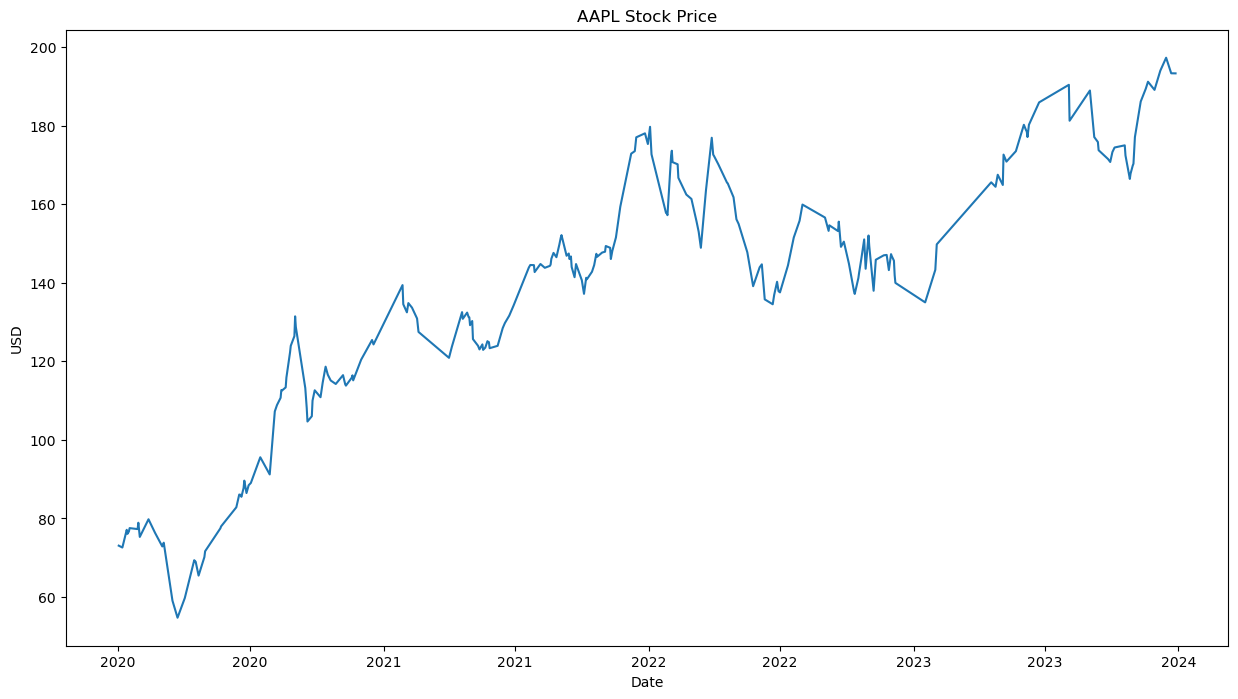

In [69]:
fig,ax = plt.subplots(figsize=(15,8))
ax.plot(df["Date"], df["Adj Close"])
ax.set(xlabel="Date",ylabel="USD",title=f"{stk_name} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

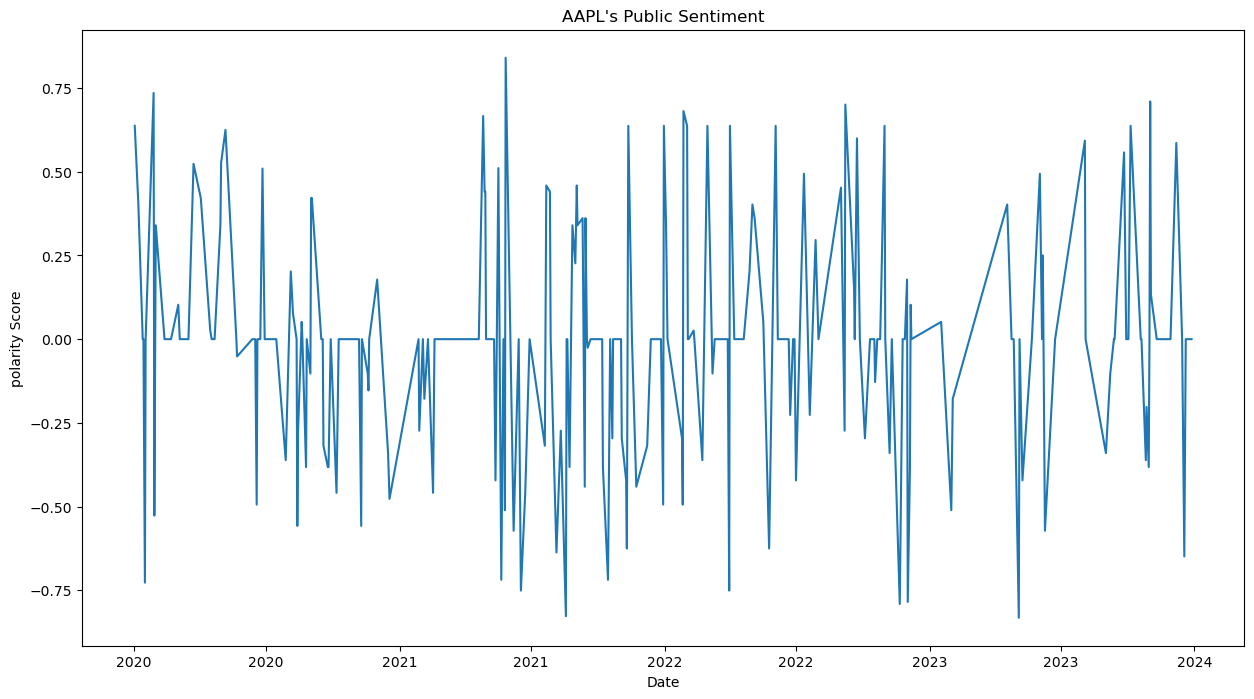

In [70]:
fig,ax = plt.subplots(figsize=(15,8))
ax.plot(df["Date"], df["polarity_score"])
ax.set(xlabel="Date",ylabel="polarity Score",title=f"{stk_name}'s Public Sentiment")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

In [71]:
# fin_df = appl_df[["Date","Close","sentence_score"]]
fin_df=df
# fin_df = fin_df.reset_index(drop=True)
print(fin_df.shape)
fin_df.head()

(252, 9)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,polarity_score
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059425,135480400,AAPL,0.6369
1,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582642,108872000,AAPL,0.4019
2,2020-01-13,77.910004,79.267502,77.787498,79.239998,77.099762,121532000,AAPL,0.0
3,2020-01-14,79.175003,79.392502,78.042503,78.169998,76.058662,161954400,AAPL,0.0
4,2020-01-16,78.397499,78.925003,78.022499,78.809998,76.681396,108829200,AAPL,-0.7269


In [72]:
def SentimentAdjustedMA(df, ma_days):
    def weight_multiplier(close,sent_score):
        maxi = max(close)
        mini = min(close)
        len_close = len(close)
        if len_close<2:
            interval = math.sqrt(close[0])
        else:
            interval = statistics.variance(close)
        max_var = interval
        weighted=0
        for i in range(len_close):
            if sent_score[i] < 0:
                weighted += close[i] + (2*sent_score[i]*max_var)
            else:
                weighted += close[i] + (sent_score[i]*max_var)
        return weighted/len_close-1
    samas = [df.loc[0,"Adj Close"]]
    rows = df.shape[0]
    for i in range(1,rows):
        if i < ma_days:
            mini_df = df.iloc[:i+1,:]
        elif i + ma_days >= rows:
            mini_df = df.iloc[i:,:]
        else:
            mini_df = df.iloc[i-ma_days+1:i+1,:]
        sama_value = weight_multiplier(mini_df["Adj Close"].tolist(),mini_df["polarity_score"].tolist())
        samas.append(sama_value)
    return samas

In [73]:
sma5= SentimentAdjustedMA(fin_df, ma_days=5)
fin_df["SMA(5)"] = sma5
sma20= SentimentAdjustedMA(fin_df, ma_days=10)
fin_df["SMA(20)"] = sma20
fin_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,polarity_score,SMA(5),SMA(20)
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059425,135480400,AAPL,0.6369,73.059425,73.059425
1,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582642,108872000,AAPL,0.4019,71.880069,71.880069
2,2020-01-13,77.910004,79.267502,77.787498,79.239998,77.099762,121532000,AAPL,0.0,75.380049,75.380049
3,2020-01-14,79.175003,79.392502,78.042503,78.169998,76.058662,161954400,AAPL,0.0,74.979536,74.979536
4,2020-01-16,78.397499,78.925003,78.022499,78.809998,76.681396,108829200,AAPL,-0.7269,73.724540,73.724540


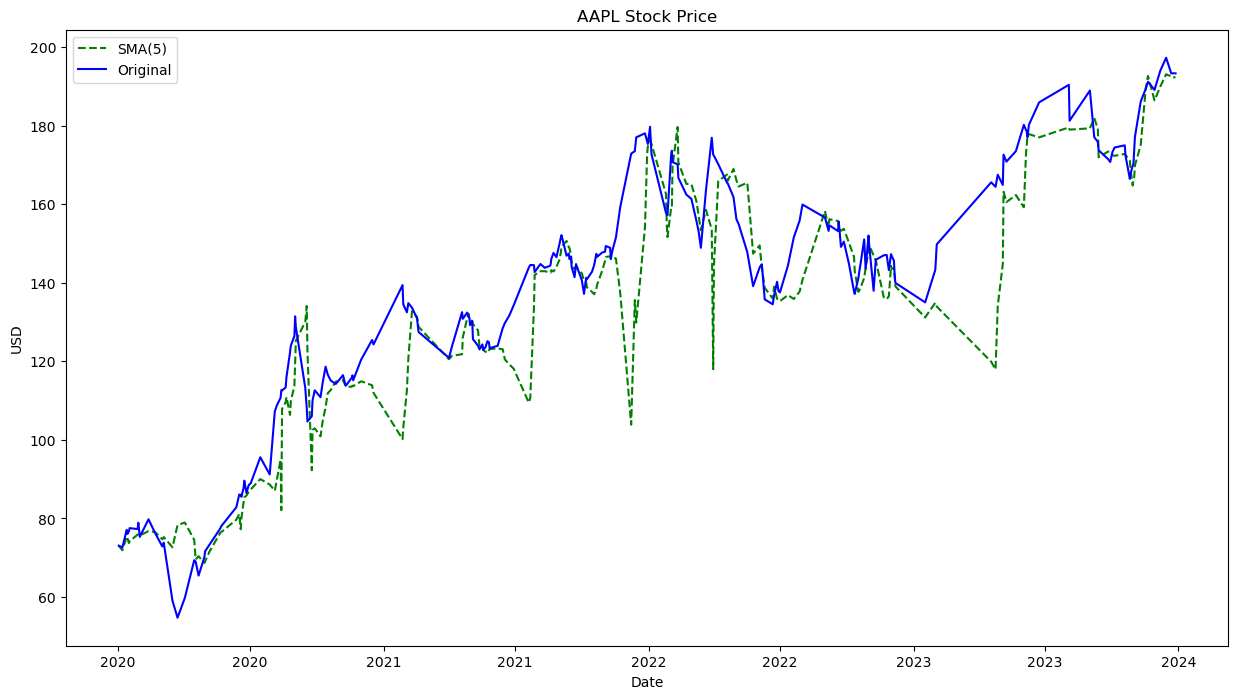

In [74]:
fig,ax = plt.subplots(figsize=(15,8))
ax.plot(fin_df["Date"], fin_df["SMA(5)"], label="SMA(5)", linestyle="--", color="g")
ax.plot(fin_df["Date"], fin_df["Adj Close"], label="Original", color="b")
ax.set(xlabel="Date",ylabel="USD",title=f"{stk_name} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.legend()
plt.show()

In [75]:
# Sort the dataframe by the 'Date' column
fin_df = fin_df.sort_values(by='Date')

# Reset the index to keep the dataframe tidy
fin_df = fin_df.reset_index(drop=True)

Final Portfolio Value: $7760.43
Sharpe Ratio: 2.16
Number of Trades Executed: 99
Win Ratio: 0.21


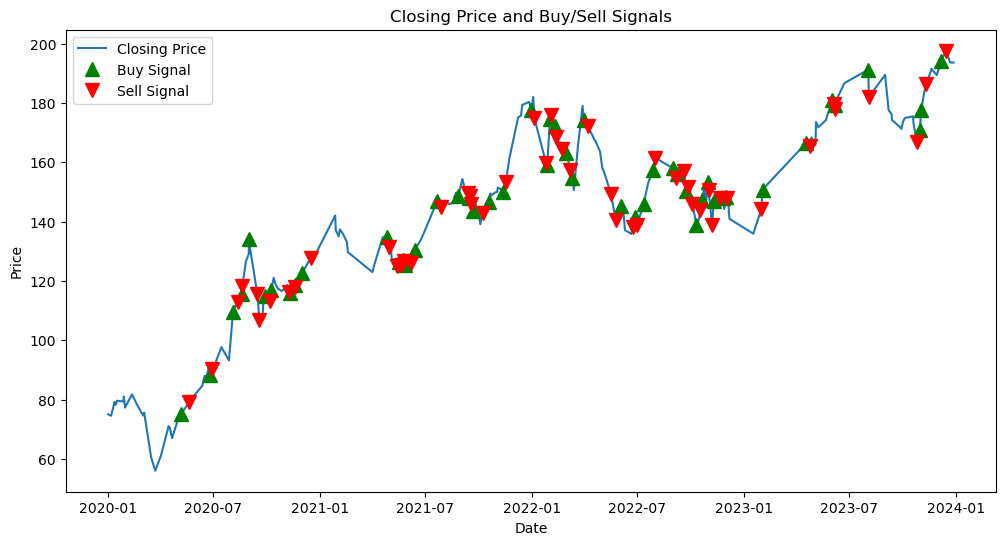

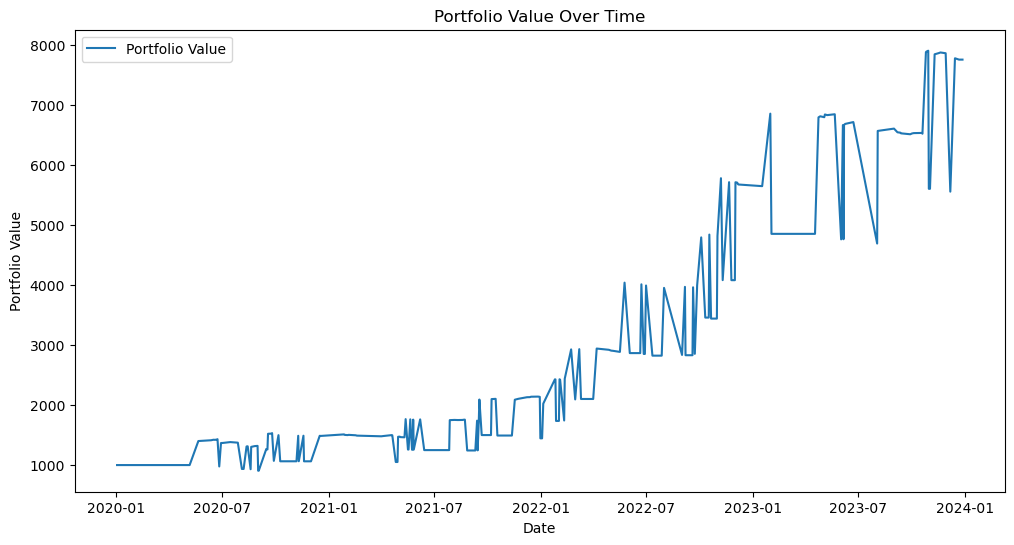

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Generate signals based on polarity score and additional filter (SMA)
def generate_signals(df):
    df['SMA'] = df['Close'].rolling(window=20).mean()  # 20-day simple moving average
    df['Signal'] = 0
    df['Signal'] = np.where((df['polarity_score'] > 0) & (df['Close'] > df['SMA']), 1, df['Signal'])
    df['Signal'] = np.where((df['polarity_score'] < 0) & (df['Close'] < df['SMA']), -1, df['Signal'])
    df['Order'] = df['Signal'].diff()
    return df

# Calculate returns and performance metrics with stop-loss, take-profit, and position sizing
def calculate_performance(df, initial_cash=1000, stop_loss_pct=0.10, take_profit_pct=0.20, position_size_pct=0.20):
    cash = initial_cash
    position = 0
    purchase_price = 0
    portfolio_values = []
    
    for index, row in df.iterrows():
        if row['Order'] == -1 and cash > 0:  # Buy signal
            position = (cash * position_size_pct) / row['Close']
            cash += position * row['Close']
            purchase_price = row['Close']
        elif row['Order'] == 1 and position > 0:  # Sell signal
            cash -= position * row['Close']
            position = 0
        elif position > 0:
            if row['Close'] < purchase_price * (1 - stop_loss_pct):  # Stop-loss condition
                cash += position * row['Close']
                position = 0
                df.loc[index, 'Order'] = -1  # Mark this as a sell due to stop-loss
            elif row['Close'] > purchase_price * (1 + take_profit_pct):  # Take-profit condition
                cash += position * row['Close']
                position = 0
                df.loc[index, 'Order'] = -1  # Mark this as a sell due to take-profit

        portfolio_value = cash + position * row['Close']
        portfolio_values.append(portfolio_value)

    df['Portfolio Value'] = portfolio_values
    final_portfolio_value = portfolio_values[-1]
    returns = df['Portfolio Value'].pct_change().dropna()
    sharpe_ratio = (252**0.5) * returns.mean() / returns.std()  # Assuming 252 trading days in a year
    total_trades = len(df[df['Order'].abs() == 1])
    winning_trades = len(df[(df['Order'] == -1) & (df['Close'] > df['Close'].shift(1))])
    win_ratio = winning_trades / total_trades if total_trades > 0 else 0

    performance = {
        "Final Portfolio Value": final_portfolio_value,
        "Sharpe Ratio": sharpe_ratio,
        "Number of Trades Executed": total_trades,
        "Win Ratio": win_ratio
    }

    return performance

# Load your dataframe
# Ensure that the 'Date' column is in datetime format and sort by date
fin_df['Date'] = pd.to_datetime(fin_df['Date'])
fin_df = fin_df.sort_values(by='Date')

# Generate signals and calculate performance
fin_df = generate_signals(fin_df)
performance = calculate_performance(fin_df)

# Print performance metrics
print(f"Final Portfolio Value: ${performance['Final Portfolio Value']:.2f}")
print(f"Sharpe Ratio: {performance['Sharpe Ratio']:.2f}")
print(f"Number of Trades Executed: {performance['Number of Trades Executed']}")
print(f"Win Ratio: {performance['Win Ratio']:.2f}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(fin_df['Date'], fin_df['Close'], label='Closing Price')

# Plot buy signals
buy_signals = fin_df[fin_df['Order'] == 1]
plt.plot(buy_signals['Date'], buy_signals['Close'], '^', markersize=10, color='g', label='Buy Signal')

# Plot sell signals
sell_signals = fin_df[fin_df['Order'] == -1]
plt.plot(sell_signals['Date'], sell_signals['Close'], 'v', markersize=10, color='r', label='Sell Signal')

plt.title('Closing Price and Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot portfolio value
plt.figure(figsize=(12, 6))
plt.plot(fin_df['Date'], fin_df['Portfolio Value'], label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

final_path=current_directory+"/signals.csv"
fin_df.to_csv('final_path', index=False)  # Adjust the path to your desired output file location




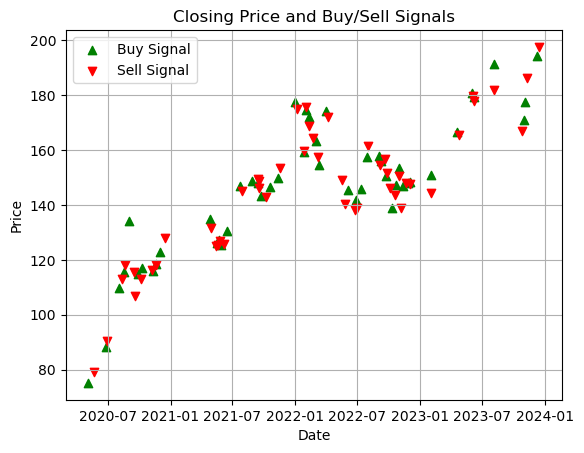

In [77]:
# Plot buy signals
buy_signals = fin_df[fin_df['Order'] == 1]
plt.scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='green', label='Buy Signal', alpha=1)

# Plot sell signals
sell_signals = fin_df[fin_df['Order'] == -1]
plt.scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.title('Closing Price and Buy/Sell Signals')
plt.xlabel('Date')


plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

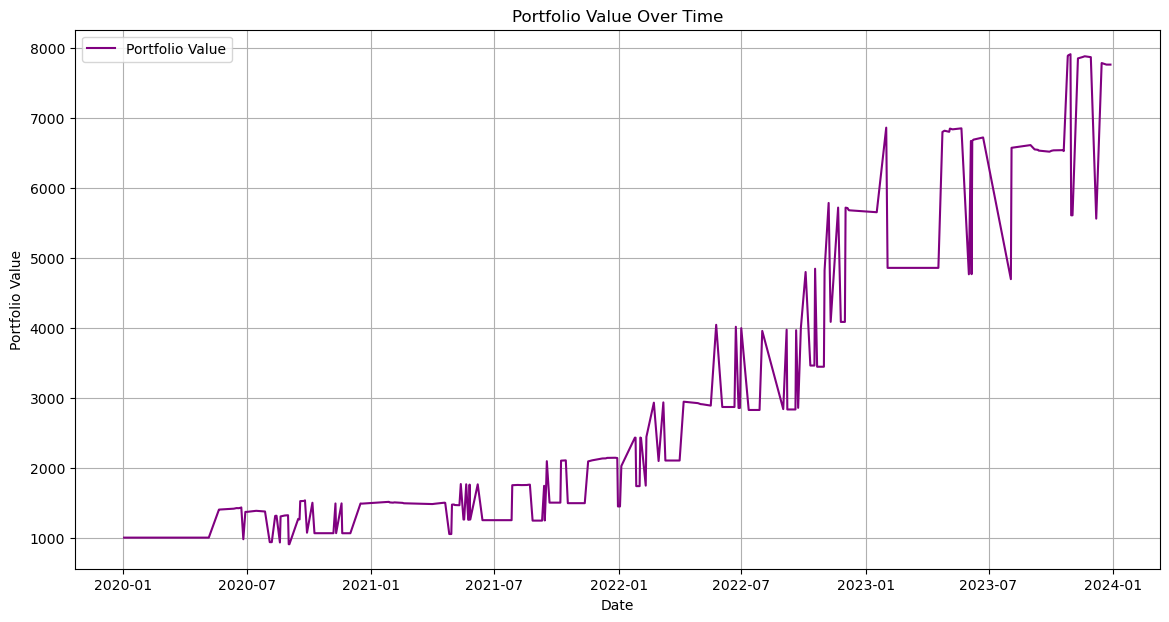

Final Portfolio Value: $7760.43
Sharpe Ratio: 2.16
Number of Trades Executed: 99
Win Ratio: 0.21


In [78]:
# Plotting the Portfolio Value over Time
plt.figure(figsize=(14, 7))
plt.plot(fin_df['Date'], fin_df['Portfolio Value'], label='Portfolio Value', color='purple')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid()
plt.show()

# Print performance metrics
print(f"Final Portfolio Value: ${performance['Final Portfolio Value']:.2f}")
print(f"Sharpe Ratio: {performance['Sharpe Ratio']:.2f}")
print(f"Number of Trades Executed: {performance['Number of Trades Executed']}")
print(f"Win Ratio: {performance['Win Ratio']:.2f}")